In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import arff
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [30]:
data = arff.loadarff(r"electricity-normalized.arff")
df = pd.DataFrame(data[0])
df.shape

(45312, 9)

##Data Preprocessing

In [31]:
df['class'] = df['class'].str.decode('utf-8') # remove byte string prefix
df['class'] = df['class'].replace({'UP': 1.0, 'DOWN': 0.0})
df.dropna(inplace=True)
# Encoding 'day' column
df['day'] = df['day'].map({b'1': 1, b'2': 2, b'3': 3, b'4': 4, b'5': 5, b'6': 6, b'7': 7})
#normalizing 'day' column
scaler = MinMaxScaler()
df['day'] = scaler.fit_transform(df[['day']])

df.info()

df['date'][3]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  float64
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   class      45312 non-null  float64
dtypes: float64(9)
memory usage: 3.1 MB


0.0

C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

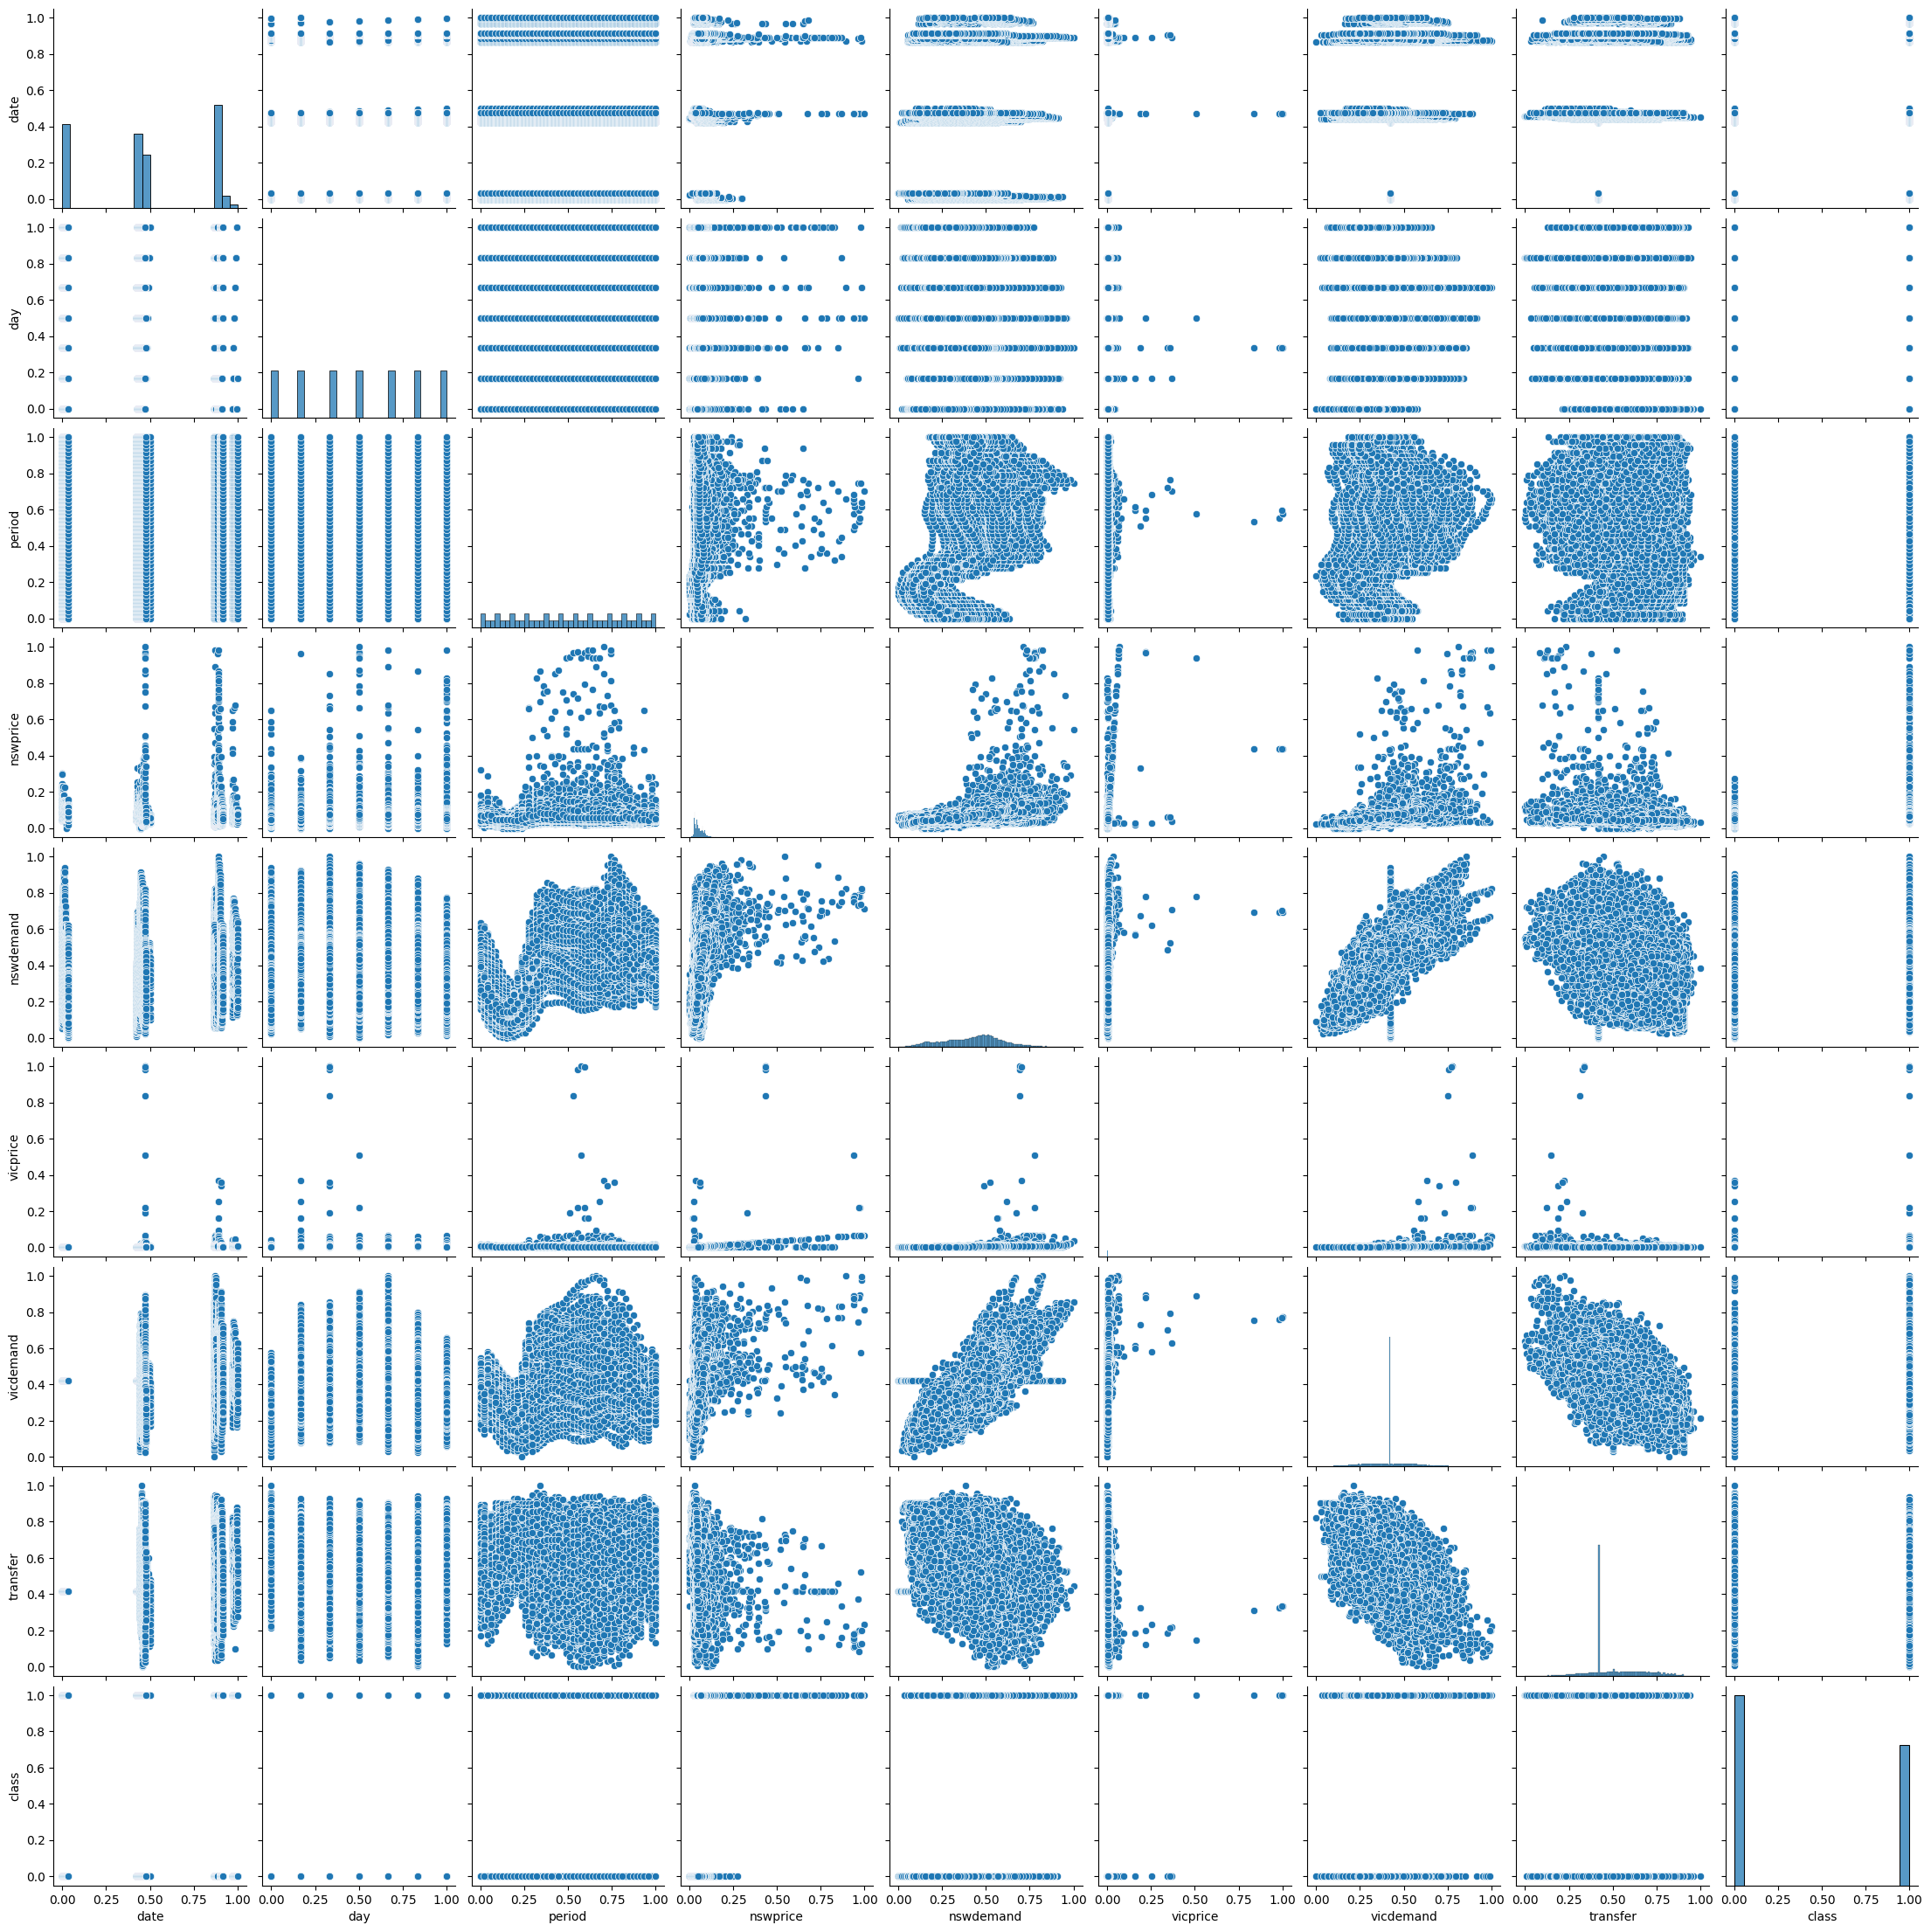

In [5]:
sns.pairplot(df)
plt.show()

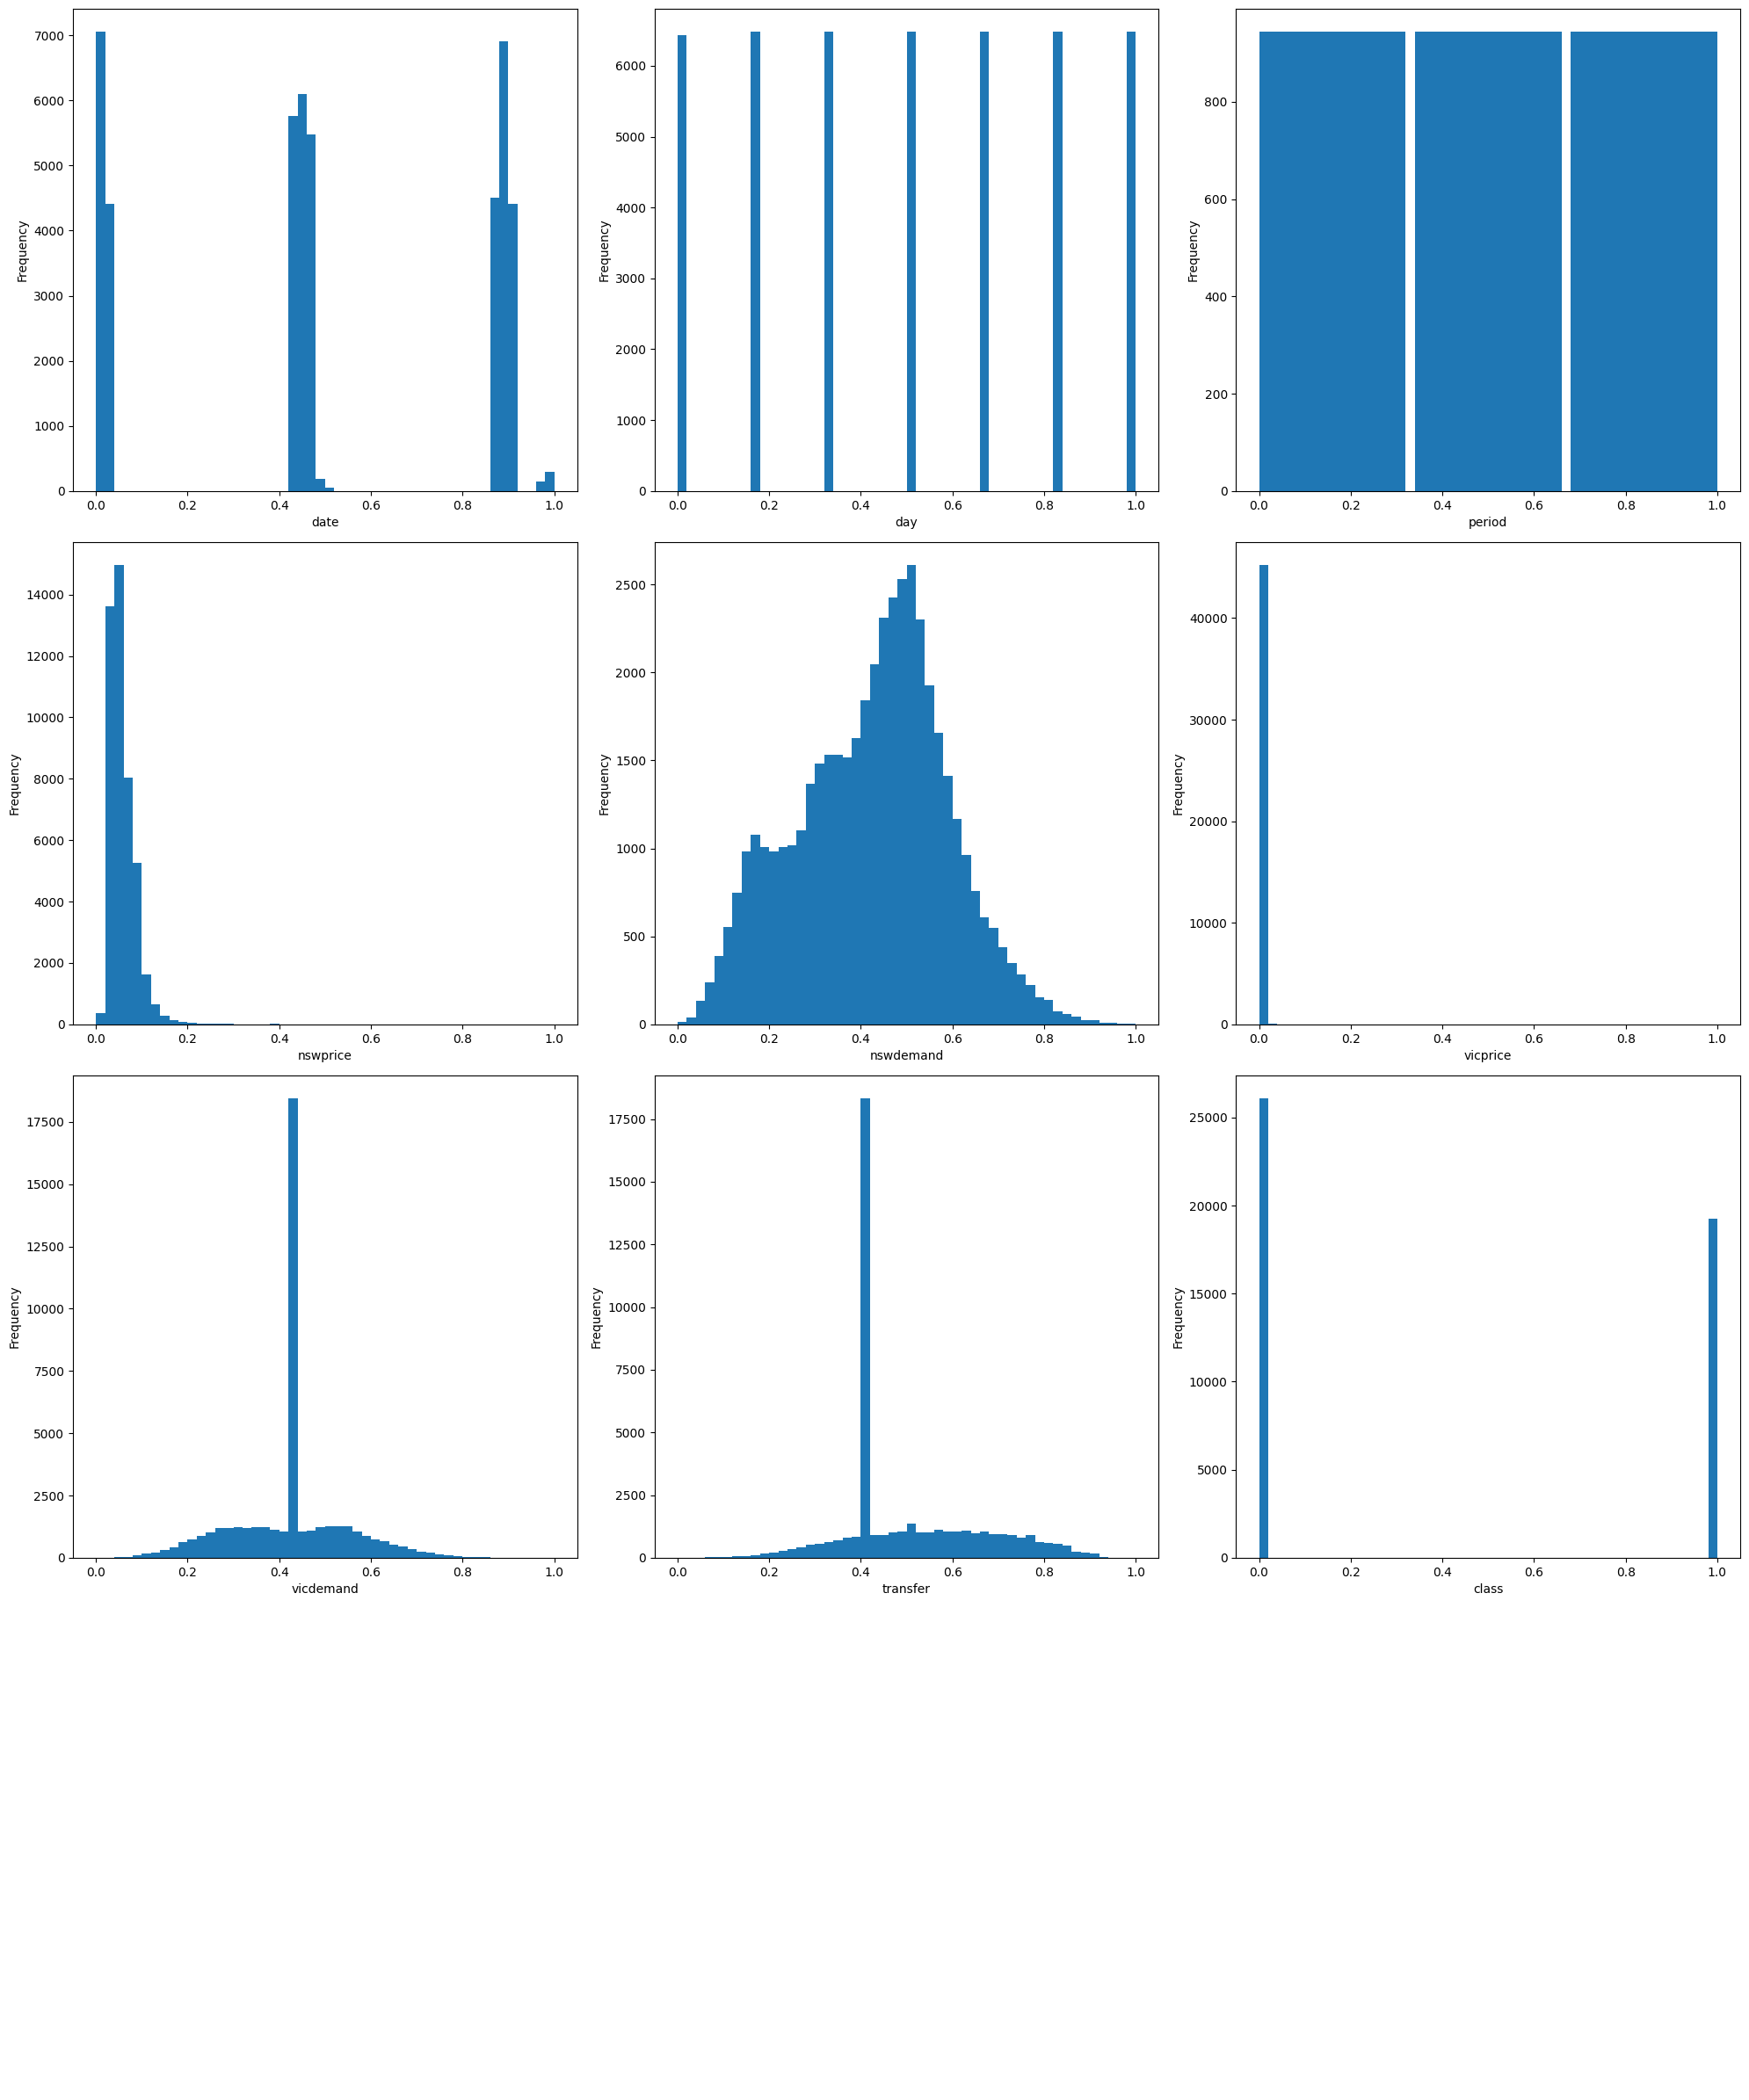

In [6]:
cols = 3
rows = len(df.columns) // cols + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 6*rows))

for i in range(rows * cols):
    if i >= len(df.columns):
        axes[i // cols, i % cols].axis('off')
    else:
        col = df.columns[i]
        ax = axes[i // cols, i % cols]
        ax.hist(df[col], bins=50)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
X_nn = df.drop(columns=['nswdemand','nswdemand'], axis=1)
y_nn = df['nswdemand']



X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype='float64')
X_test = np.array(X_test, dtype='float64')

model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')

])

model.compile(optimizer='adam', loss='MSE', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)
test_loss, test_mae = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)



Epoch 1/50
7250/7250 [==============================] - 13s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0720 - val_loss: 0.0060 - val_mean_absolute_error: 0.0595
Epoch 2/50
7250/7250 [==============================] - 11s 2ms/step - loss: 0.0063 - mean_absolute_error: 0.0604 - val_loss: 0.0051 - val_mean_absolute_error: 0.0548
Epoch 3/50
7250/7250 [==============================] - 12s 2ms/step - loss: 0.0055 - mean_absolute_error: 0.0558 - val_loss: 0.0046 - val_mean_absolute_error: 0.0517
Epoch 4/50
7250/7250 [==============================] - 11s 1ms/step - loss: 0.0048 - mean_absolute_error: 0.0525 - val_loss: 0.0039 - val_mean_absolute_error: 0.0473
Epoch 5/50
7250/7250 [==============================] - 11s 1ms/step - loss: 0.0045 - mean_absolute_error: 0.0505 - val_loss: 0.0038 - val_mean_absolute_error: 0.0465
Epoch 6/50
7250/7250 [==============================] - 11s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0479 - val_loss: 0.0044 - val_mean_absolute_error: 0.050

Test Loss: 0.002317950362339616
Test Mean Average Loss: 0.035158973187208176


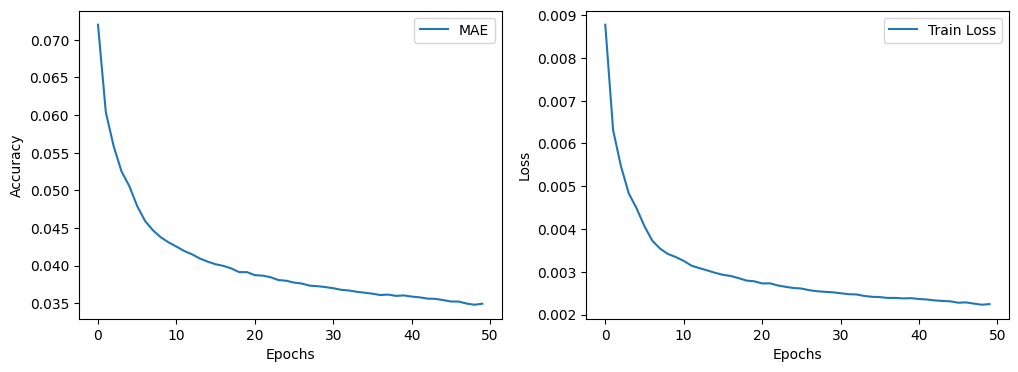

In [8]:
print('Test Loss:', test_loss)
print('Test Mean Average Loss:', test_mae)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
kf = KFold(n_splits=5, shuffle = True, random_state=42)

mse_score = []
acc_score = []
data_x = df.drop(columns=['nswdemand', 'class', 'day'], axis=1)

for train , test in kf.split(data_x):
    X_train , X_test = data_x.iloc[train,:],data_x.iloc[test,:]
    y_train , y_test = df['nswdemand'][train] , df['nswdemand'][test]

    model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='MSE', metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)
    yhat_cv_test = model.predict(X_test)

    mse = mean_squared_error(yhat_cv_test , y_test)
    mse_score.append(mse)

avg_mse_score = sum(mse_score)/10

print('Mean Squared Error of each fold : {}'.format(mse_score))
print('Avg Mean Squared Error : {}'.format(avg_mse_score))

Epoch 1/50
7250/7250 [==============================] - 12s 2ms/step - loss: 0.0098 - mean_absolute_error: 0.0760 - val_loss: 0.0067 - val_mean_absolute_error: 0.0656
Epoch 2/50
7250/7250 [==============================] - 10s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0679 - val_loss: 0.0053 - val_mean_absolute_error: 0.0560
Epoch 3/50
7250/7250 [==============================] - 10s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0053 - val_mean_absolute_error: 0.0581
Epoch 4/50
7250/7250 [==============================] - 10s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0615 - val_loss: 0.0064 - val_mean_absolute_error: 0.0651
Epoch 5/50
7250/7250 [==============================] - 10s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0599 - val_loss: 0.0058 - val_mean_absolute_error: 0.0613
Epoch 6/50
7250/7250 [==============================] - 10s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0591 - val_loss: 0.0056 - val_mean_absolute_error: 0.058

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype='float64')
X_test = np.array(X_test, dtype='float64')

def create_model(activation='relu', optimizer='adam', kernel_initializer='glorot_uniform'):
    model = Sequential([
        Dense(512, activation=activation, kernel_initializer=kernel_initializer, input_dim=8),
        Dense(256, activation=activation, kernel_initializer=kernel_initializer),
        Dense(128, activation=activation, kernel_initializer=kernel_initializer),
        Dense(64, activation=activation, kernel_initializer=kernel_initializer),
        Dense(32, activation=activation, kernel_initializer=kernel_initializer),
        Dense(1, activation="linear") 
    ])

    model.compile(optimizer="adam", loss="MSE", metrics=["mean_squared_error"])
    return model

model = KerasClassifier(build_fn = create_model, verbose = 0, kernel_initializer = 'glorot_uniform', activation = 'relu')

#testing adam, rmsprop, or sgd for best optimizer, as well as best batch size and number of epochs.
hparam = {'epochs': [50, 100], 
          'batch_size': [32,64],  
          'optimizer': ['adam', 'rmsprop'], 
          'kernel_initializer': ['glorot_uniform', 'normal'],
          'activation': ['relu','tanh','sigmoid']
          }

random_search = RandomizedSearchCV(
    model,
    param_distributions = hparam,
    n_iter = 10,
    n_jobs = -1,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    verbose = 2,
    random_state = 10

)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

X_train shape: (36249, 8)
y_train shape: (36249,)
X_train dtype: float64
y_train dtype: float64
Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Tristan H\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py", line 915, in _fit
    X, y = self._initialize(X, y)
  File "C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py", line 845, in _initialize
    self.target_encoder_ = self.target_encoder.fit(y)
  File "C:\Users\Tristan H\AppData\Roaming\Python\Python39\site-packages\scikeras\utils\transformers.py", line 175, in fit
    raise ValueError(
ValueError: Unknown label type: continuous.

To implement support, subclass KerasClassifier and override ``target_encoder`` with a transformer that supports this label type.

For information on sklearn target types, see: * https://scikit-learn.org/stable/modules/generated/sklearn.utils.multiclass.type_of_target.html * https://scikit-learn.org/stable/modules/multiclass.html

For information on the SciKeras data transformation interface, see: * https://www.adriangb.com/scikeras/stable/advanced.html#data-transformers


In [ ]:
from datetime import datetime
import time

# Define the date format
fmt = '%d %B %Y'

# Convert the start and end dates to timestamps
start_date = time.mktime(datetime.strptime('7 May 1996', fmt).timetuple())
end_date = time.mktime(datetime.strptime('5 December 1998', fmt).timetuple())

# Denormalize the 'date' column
df['denormalized_date'] = df['date'] * (end_date - start_date) + start_date
df['denormalized_date'] = pd.to_datetime(df['denormalized_date'], unit='s')


c:\Users\Tristan H\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


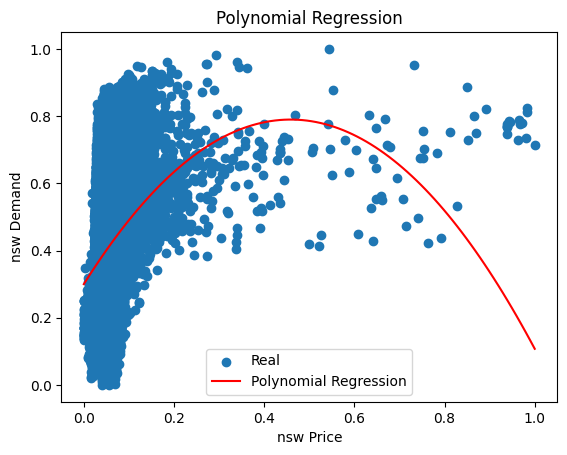

In [ ]:
# Define the features and target variable
X = df[['day', 'nswprice', 'date']]
y = df['nswdemand']

#poly features
degree = 2  # degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Fit model
poly_regression_model = LinearRegression()
poly_regression_model.fit(X_poly, y)

X_line = np.linspace(X['nswprice'].min(), X['nswprice'].max(), 100).reshape(-1, 1)
X_line_poly = poly_features.transform(np.hstack([np.ones_like(X_line), X_line, np.ones_like(X_line)]))
y_line_pred = poly_regression_model.predict(X_line_poly)

# Plot the real values
plt.scatter(X['nswprice'], y, label='Real')

plt.plot(X_line, y_line_pred, color='red', label='Polynomial Regression')

plt.xlabel('nsw Price')
plt.ylabel('nsw Demand')
plt.title('Polynomial Regression')
plt.legend()
plt.show()



Accuracy: 0.6361028357056162
Confusion Matrix:
[[3909 1282]
 [2016 1856]]


c:\Users\Tristan H\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


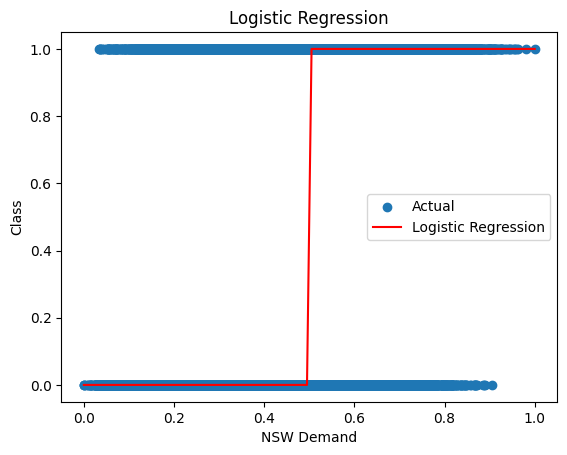

In [ ]:

X = df[['nswdemand']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

X_boundary = np.linspace(X['nswdemand'].min(), X['nswdemand'].max(), 100).reshape(-1, 1)
y_boundary_pred = logistic_regression_model.predict(X_boundary)

plt.scatter(X['nswdemand'], y, label='Actual')
plt.plot(X_boundary, y_boundary_pred, color='red', label='Logistic Regression')
plt.xlabel('NSW Demand')
plt.ylabel('Class')
plt.title('Logistic Regression')
plt.legend()
plt.show()

Epoch 1/3
37/37 [==============================] - 9s 171ms/step - loss: 0.0353
Epoch 2/3
37/37 [==============================] - 6s 170ms/step - loss: 0.0124
Epoch 3/3
9015/9015 [==============================] - 24s 3ms/step


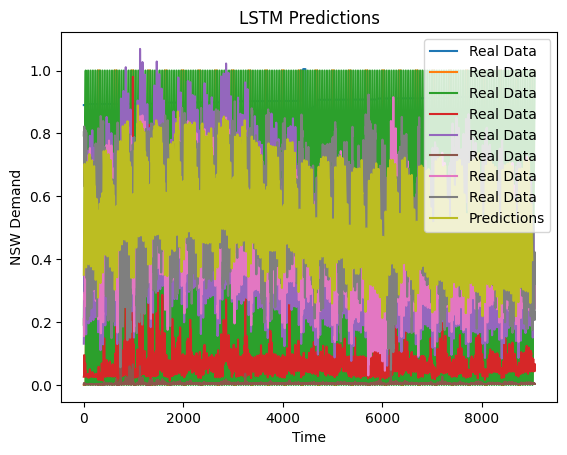

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


step_num = 48
features = ['date','day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']

def lstm_model(features, target):
    # Split data
    train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

    # Normalize
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data[features])
    test_data_scaled = scaler.transform(test_data[features])

    # training data using TimeSeriesGenerator
    train_generator = TimeseriesGenerator(train_data_scaled, train_data_scaled[:, features.index(target)],
                                          length=step_num, batch_size=1000)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(step_num, len(features))))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=3)

    test_generator = TimeseriesGenerator(test_data_scaled, test_data_scaled[:, features.index(target)],
                                         length=step_num, batch_size=1)

    predictions = model.predict(test_generator)
    predictions = predictions[:len(test_data)]

    # Denormalize only the 'nswdemand' column
   # predictions = scaler.inverse_transform(predictions.reshape(-1, 1))[:, 0]
    #test_data_denormalized = scaler.inverse_transform(test_data_scaled[:, features.index(target)].reshape(-1, 1))[:, 0]

    # Plot the predictions
    plt.plot(test_data_scaled, label='Real Data')
    plt.plot(predictions, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('NSW Demand')
    plt.title('LSTM Predictions')
    plt.legend()
    plt.show()
lstm_model(features, 'nswdemand')